<h2>CS 3780/5780 Creative Project: </h2>
<h3>Emotion Classification of Natural Language</h3>

Names and NetIDs for your group members:

Hannah Zhou (hyz4)
Victoria Yu (vwy5)
Peter Zheng (pcz3)

Team Name: Queens Never Cry

<h3>Introduction:</h3>

<p> The creative project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The past programming projects provide templates for how to do this (and you can reuse part of your code if you wish), and the lectures provide some of the methods you can use. So, this creative project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is classifying texts to human emotions. Through words, humans express feelings, articulate thoughts, and communicate our deepest needs and desires. Language helps us interpret the nuances of joy, sadness, anger, and love, allowing us to connect with others on a deeper level. Are you able to train an ML model that recognizes the human emotions expressed in a piece of text? <b>Please read the project description PDF file carefully and follow the instructions there. Also make sure you write your code and answers to all the questions in this Jupyter Notebook </b> </p>
<p>


<h2>Part 0: Preliminaries</h2><p>

<h3>0.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [ ]:
%pip install -q -r requirements.txt # if have access to requirements.txt 
%pip install pandas
%pip install numpy
%pip install nltk
%pip install pyenchant # Note that some versions of MacOs may have issues with this package
%pip install fuzzywuzzy
%pip install scikit-learn
%pip install transformers
%pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np

# For SVM and XGBoost
import random
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize # Note: You may need to download the punkt corpus using nltk.download('punkt')
from nltk.corpus import stopwords # Note: You may need to download the stopwords corpus using nltk.download('stopwords')
import enchant
from fuzzywuzzy import fuzz

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC # One vs Rest Classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier

# For BERT
from transformers import TFDistilBertForSequenceClassification, AutoTokenizer
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

<h3>0.2 Accuracy:</h3><p>
To measure your performance in the Kaggle Competition, we are using accuracy. As a recap, accuracy is the percent of labels you predict correctly. To measure this, you can use library functions from sklearn. A simple example is shown below. 
<p>

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = [3, 2, 1, 0, 1, 2, 3]
y_true = [0, 1, 2, 3, 1, 2, 3]
accuracy_score(y_true, y_pred)

<h2>Part 1: Basics</h2><p>
Note that your code should be commented well and in part 1.4 you can refer to your comments.

<h3>1.1 Load and preprocess the dataset:</h3><p>
We provide how to load the data on Kaggle's Notebook.
<p>

In [ ]:
# For KAGGLE NOTEBOOK only. We are running on VSCODE, so skip to the next code cell.
train = pd.read_csv("/kaggle/input/cs-3780-5780-how-do-you-feel/train.csv")
train_text = train["text"]
train_label = train["label"]

test = pd.read_csv("/kaggle/input/cs-3780-5780-how-do-you-feel/test.csv")
test_id = test["id"]
test_text = test["text"]

In [ ]:
# VSCODE: load the data files
train = pd.read_csv("train.csv")
train_text = train["text"]
train_label = train["label"]

test = pd.read_csv("test.csv")
test_id = test["id"]
test_text = list(test["text"])

# First shuffle the dataset. Not required but just in case there is some sort of ordering that we just aren't aware of. 
random.seed(42)  # generate a random seed  
combined_data = list(zip(train_text, train_label))
random.shuffle(combined_data)
train_text, train_label = zip(*combined_data) 

# Second, split the data. Follow heuristic advice about 70/30 split. 
train_size = int(len(train_text) * 0.7)
train_set = np.array(train_text[:train_size])
val_set = np.array(train_text[train_size:])
train_labels = np.array(train_label[:train_size])
val_labels = np.array(train_label[train_size:])

<h3> 1.1 Preprocessing Data for SVM and XGBoost: </h3>

Refer to 1.4.1 to understand the preprocessing steps for SVM and XGBoost. Note that this step differs from the creative method using transformers.

In [ ]:
# Third, we preprocess the textual data so that's trivial words, symbols, or weird abbreviations are removed.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

d = enchant.Dict("en_US")

def preprocess_text(text):
    """
    Tokenizes, lemmatizes, removes stopwords, and normalizes the input text.
    - Converts to lowercase.
    - Removes stopwords.
    - Lemmatizes tokens to their base forms. (i.e: running -> run)
    """
    tokens = word_tokenize(text.lower())  # tokenize and convert to lowercase. returns a list.
    
    for token in tokens:
        if not d.check(token):
            suggestions = d.suggest(token) # returns a list of suggestions ordered by highest relevance
            if suggestions:
                if fuzz.ratio(token, suggestions[0]) > 90: # check if edit distance is less than 10%
                    tokens[tokens.index(token)] = suggestions[0]
                else:
                    tokens.remove(token) # remove the token if it's gibberish
    
    tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens if token.isalnum() and token not in stop_words 
    ]
    return " ".join(tokens) # convert back into a string 

# Then apply the preprocess function to the text in train_set and val_set and test_set
train_set = [preprocess_text(text) for text in train_set]
val_set = [preprocess_text(text) for text in val_set]
test_set = [preprocess_text(text) for text in test_text]

<h3>1.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 0.1.

In [ ]:
# SVM
# First, use TF-IDF Vectorizer to convert the text data into a matrix of TF-IDF features
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))  # Using unigrams and bigrams

# Transform the training and validation sets
train_set_tfidf = vectorizer.fit_transform(train_set)
val_set_tfidf = vectorizer.transform(val_set)

# Create a pipeline with TF-IDF vectorizer and SVM model
svm_model = LinearSVC(C=0.5) 

# Now we can do cross-validation using Stratified KFold
# StratifiedKFold ensures that each fold has approximately the same percentage of samples of each class
# Basically we could also just use a loop to do this (or what we did in the notebook) but this is more convenient.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training data
cv_scores = cross_val_score(svm_model, train_set_tfidf, train_labels, cv=cv, scoring='accuracy')

# Print out the cross-validation results
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.3f}")
print(f"Standard Deviation: {cv_scores.std():.3f}")

# Now fit the model on the entire training set and predict on the validation set
svm_model.fit(train_set_tfidf, train_labels)

# Predict on the validation set
svm_preds = svm_model.predict(val_set_tfidf)

# Evaluate the model on the validation set
svm_accuracy = accuracy_score(val_labels, svm_preds)
print(f"\nSVM (LinearSVC) Validation Accuracy: {svm_accuracy:.3f}")
print("SVM Classification Report:\n", classification_report(val_labels, svm_preds))
print("SVM Confusion Matrix:\n", confusion_matrix(val_labels, svm_preds))

Original Param_Grid for XGBoost
```
param_grid = {
# 'tfidfvectorizer__max_features': [5000, 10000, 15000],
#  'xgbclassifier__max_depth': [10,11,12], 
#  'xgbclassifier__min_child_weight': [0.6, 0.7, 0.8, 0.9],
#  'xgbclassifier__gamma': [1.0, 1.1, 1.2, 1.3]
# 'xgbclassifier__n_estimators': [50, 100, 150],
# 'xgbclassifier__learning_rate': [0.05, 0.1, 0.15],
# 'xgbclassifier__eta': [0.1], [0.5], [1]
# 'xgbclassifier__booster': ['gbtree', 'gblinear', 'dart']
}
```

In [ ]:
# XGBoost with tf-idf Vectorizer and GridSearchCV

#gridsearch for max_features, max_depth, n_estimators, learning_rate, gamma, min_child_weight, colsample_by, eta, booster
param_grid = {
# 'tfidfvectorizer__max_features': [5000, 10000, 15000],
#  'xgbclassifier__max_depth': [10,11,12], #best is 12
#  'xgbclassifier__min_child_weight': [0.6, 0.7, 0.8, 0.9], #best is 0.7
#  'xgbclassifier__gamma': [1.0, 1.1, 1.2, 1.3]
# 'xgbclassifier__n_estimators': [50, 100, 150],
# 'xgbclassifier__learning_rate': [0.05, 0.1, 0.15],
 'xgbclassifier__eta': [0.1],
}

# Create a pipeline that transforms the text data into a tf-idf matrix and then trains an XGBoost classifier on it.
pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    XGBClassifier( gamma = 1.1, max_depth=12, min_child_weight=0.7,learning_rate=0.15)
)

# Create a GridSearchCV object that uses the pipeline and the parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object on the training set
grid_search.fit(train_set, train_labels)

# Print the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict the labels of the validation set. Print the results for further analysis.
val_predictions = best_model.predict(val_set)
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy:.3f}")
conf_matrix = confusion_matrix(val_labels, val_predictions)
print(conf_matrix)
class_report = classification_report(val_labels, val_predictions)
print(class_report)

In [ ]:
# Predict on the test set
test_predictions = best_model.predict(test_set)

<h3>1.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

### 1.4.1 How did you formulate the learning problem?

The goal of the learning problem is to classify the emotion sentiment of a given sentence. We envisioned our model’s input as being a sentence represented by a string, and the output is a numerical class label ranging from 0 to 27 that corresponds to the emotion conveyed by this sentence. The success metrics we hoped to achieve are at least 65% (beating Tiny Piney) for our naive method, and at least 74% (beating Zero Hero) for our creative method.

After looking through the nature of the dataset, we realized that there needs to be preprocessing of the data to filter out gibberish or irrelevant words. First, we used the a tokenizer to tokenize the given sentence, and for each of the tokens, if it was not in a dictionary from Enchant, we either replaced the word with a the most likely suggestion by `Enchant` if the fuzz (similarity) ratio between the two was greater than 90%, or removed the token altogether if it didn’t fit this criteria because it is most likely gibberish. We further processed these words by filtering out stopwords from the `NTLK` toolkit, which are words that are not likely to be helpful towards sentiment analysis, such as “I.” 

In order to represent our tokens after preprocessing, we first used a lemmatizer to standardize them; the purpose of a lemmatizer is to reduce words to their root forms; for instance, “change,” “changing,” and “changed” would be understood to have essentially the same meaning. We also used the `ngrams` library, which allows further flexibility in feature determination by capturing a sequence of n words as a feature. Specifically, we had the computer figure out an optimized mix of uni-grams and bi-grams to tokenize and extract the pure string of each word (or two words for the bi-gram) in the textual data. For example if we have the sentence "I am happy", the unigrams would be "I", "am", "happy" and the bigrams would be "I am", "am happy". We attempted to use tri-grams as well, but found that performance was best solely with a mix of uni-grams and bi-grams.

### 1.4.2 Which two learning methods from class did you choose and why did you made the choices?

We chose to use `SVM` and `XGBoost` because we thought that a discriminative approach would work well because there is an abundance of training data available, which is conducive to learning clear boundaries between the 28 classes. Additionally, from the lectures on ensemble learning, we thought that ensemble learning would help decrease the variance of predictions. 

For our first method, we chose to use a **one-vs-rest SVM**, which creates a different SVM for each class, and puts that class as one of the binary labels, and the rest of the classes as the other binary label, and aggregates the decisions of these SVM’s to classify a specific data point. We first preprocessed the data as mentioned in 1.4.1 (with `NLTK` tokenizer and lemmatizer). Then, we passed in the training data into **scikit-learn’s Linear SVC** model, and manually adjusted the hyperparameter `C` (which is the penalty parameter of the error term, and is roughly inversely proportional to the strength of regularization) until we felt that it could not improve any more. Our final predictions came from a pipeline with two components; the Linear SVC model, and **scikit-learn’s TF-IDF (term frequency-inverse document frequency) vectorizer**. This vectorizer converts the training data into a matrix of features, tuned with a hyperparameter max_features, where each entry corresponds to a float that reflects how important a word in the document is. After lots of tuning, **we ended up with an accuracy of 71% on the test set and 73% on the validation set.**

For our second method, we chose to use `XGBoost`, which combines the predictions of multiple gradient-boosted decision trees. The preprocessing step remained the same as 1.4.1 and we also used a vectorizer and pipeline as SVM did. 

A huge issue with our `SVM` and `XGBoost` models is that our tokens **did not adequately capture context and order within the sentence**. For instance, sentences such as “I am happy but sad” and “I am sad but happy,” which have almost completely opposite meanings, would essentially be treated identically. Additionally, hyperparameter tuning did not lead to significant improvements in the accuracy; even through extensive tuning over multiple days, we were not able to reach Zero Hero and opted to go beyond scikit-learn for our creative solution.

### 1.4.3 How did you do the model selection?

For the `SVM`, we divided up our training data into a training set and a validation set, with a 70/30 split as a heuristic taught in lecture. We used **scikit-learn’s Grid Search** to find the parameter `C` that produced a strong validation accuracy (> 70%) of the SVM, and the `max_features` for the TF-IDF Vectorizer, which approximates the test accuracy, and set our parameters to those accordingly. In order to capture more accuracy metrics, we also used **k-fold cross-validation** on the training data using **scikit-learn’s Stratified K-Fold library** for our SVM to ensure that the validation error was strong across different subsamples of the data. We ended up using: `C=0.5`, `max-iter=7000`. 

For `XGBoost`, we used the same train/validation split and used `GridSearch` to find the parameters: max_features (for TF-IDF), max_depth, min_child_weight, gamma, eta, learning_rate that produced the best validation accuracy. We ended up using `learning_rate=0.15`, `gamma = 1.1`, `max_depth=12`, `min_child_weight=0.7`, `eta=0.1`, `max_features=10000`. Our cross-validation scores were [0.69928571 0.71214286 0.70357143 0.70071429 0.695], so we had a mean accuracy of 0.702 and a standard deviation of 0.006. Then, made predictions with that model and we got **a validation accuracy of 0.723.**

### 1.4.4 Does the test performance reach the first baseline "Tiny Piney"? (Please include a screenshot of Kaggle Submission)

Both SVM and XGBoost reached the Tiny Piney Baseline; SVM had 0.69820 test accuracy and XGBoost had 0.71070 test accuracy.

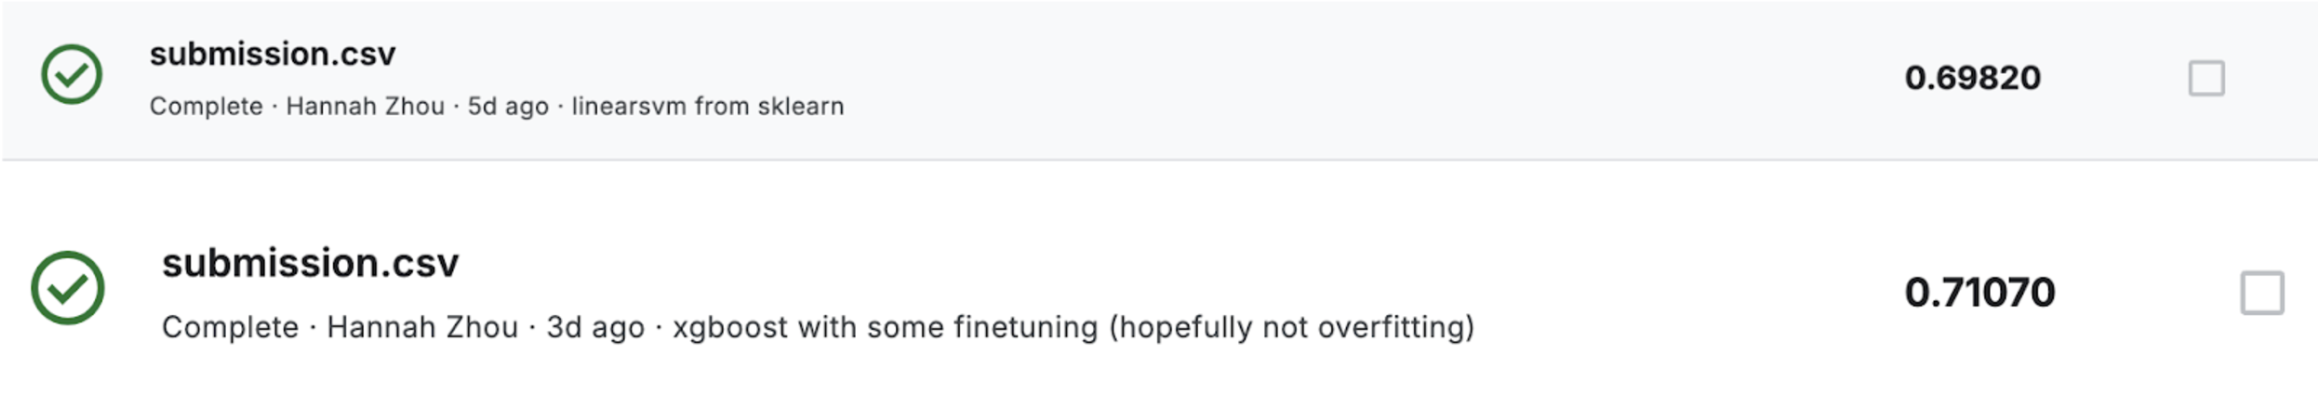

<h2>Part 2: Be creative!</h2><p>

<h3>2.1 Open-ended Code:</h3><p>
You may follow the steps in part 1 again but making innovative changes like using new training algorithms, etc. Make sure you explain everything clearly in part 2.2. Note that beating "Zero Hero" is only a portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [ ]:
def tune_hyperparameters(train_texts, train_labels, val_texts, val_labels, param_grid, num_labels):
    """
    Tune hyperparameters for DistilBERT using grid search.
    
    Args:
    - train_texts: List of training texts.
    - train_labels: List of training labels.
    - val_texts: List of validation texts.
    - val_labels: List of validation labels.
    - param_grid: Dictionary of hyperparameters to search.
    - num_labels: Number of output labels for classification.
    
    Returns:
    - best_model: Model with the best validation accuracy.
    - best_params: Best hyperparameters.
    """
    best_accuracy = 0
    best_params = None
    best_model = None
    
    for params in ParameterGrid(param_grid):
        print(f"Testing parameters: {params}")
        
        learning_rate = params.get("learning_rate", 5e-5)
        batch_size = params.get("batch_size", 16)
        max_length = params.get("max_length", 128)
        num_epochs = params.get("epochs", 3)
        
        # Load tokenizer and preprocess data (do not use nltk)
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        
        def preprocess_data(texts, labels, max_length):
            # The tokenizer function takes the list of texts, pads them to the maximum length, truncates them if they are longer than the maximum length, and returns the output as a TensorFlow tensor.
            tokenized = tokenizer(
                list(texts), padding=True, truncation=True, max_length=max_length, return_tensors="tf"
            )
            # This code turns the dataset into a Tensorflow dataset, then batches it. All these steps are done to help prepare the data for the model. Ensure no ResourceExhaustedError.
            dataset = tf.data.Dataset.from_tensor_slices((
                dict(tokenized),
                tf.convert_to_tensor(labels, dtype=tf.int32)
            ))
            return dataset.batch(batch_size)
        
        train_dataset = preprocess_data(train_texts, train_labels, max_length)
        val_dataset = preprocess_data(val_texts, val_labels, max_length)
        
        model = TFDistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=num_labels
        )

        # decreasing learning rate at a polynomial decay. Note that this method did not improve the model.
        # kept it here for the report, we are not using it as our optimizer's learning_rate is already set to 5e-5
        lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        end_learning_rate=1e-6
        )

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # from_logits=True because the model returns logits
        metrics = ['accuracy']
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
        # Train model
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=num_epochs,
            verbose=1
        )
        
        # Evaluate on validation data
        val_accuracy = max(history.history['val_accuracy'])
        print(f"Validation accuracy: {val_accuracy}")
        
        # Update best model if current accuracy is better
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params
            best_model = model
    
    print(f"Best hyperparameters: {best_params}")
    print(f"Best validation accuracy: {best_accuracy}")
    return best_model, best_params

# Define hyperparameter grid
param_grid = {
    "learning_rate": [5e-5], #higher lr is better with polynomial decay
    "batch_size": [16],
    "max_length": [55, 60, 65], #plateau at 60
    "epochs": [3] 
}

# Run hyperparameter tuning
best_model, best_params = tune_hyperparameters(
    train_set, train_labels, val_set, val_labels, param_grid, num_labels=28
)

In [ ]:
# Some history of the accuracies
# Validation accuracy: 0.7356666922569275
#Testing parameters: {'batch_size': 16, 'epochs': 3, 'learning_rate': 5e-05, 'max_length': 25}

#Best hyperparameters: {'batch_size': 16, 'epochs': 3, 'learning_rate': 5e-05, 'max_length': 40}
#Best validation accuracy: 0.7716666460037231

#Validation accuracy: 0.7746666669845581 for max_length 60

# Best hyperparameters: {'batch_size': 16, 'epochs': 3, 'learning_rate': 5e-05, 'max_length': 60}
# w/ lr schedule
# Best validation accuracy: 0.7773333191871643
# although highest val acc, the model is overfitting more so did not achieve
# a higher test acc than the previous model

In [ ]:
def preprocess_test_text(test_text, tokenizer, max_length):
    """Preprocesses the test text by tokenizing and formatting.
       A different function is used since test_text only includes the data, not the labels."""
    tokenized = tokenizer(
        test_text,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    return dict(tokenized)

def get_predictions_in_batches(model, test_text, tokenizer, max_length, batch_size):
    """Processes test data in batches to avoid memory issues.
       Follows the idea from past coding assignments. Only difference is we do not do any shuffling of the batch indices. """
    predictions = []
    for i in range(0, len(test_text), batch_size):
        batch_text = test_text[i:i + batch_size]
        batch_inputs = preprocess_test_text(batch_text, tokenizer, max_length)
        batch_logits = model(**batch_inputs).logits # Get the logits from the model.
        batch_predictions = tf.argmax(batch_logits, axis=-1).numpy()
        predictions.extend(batch_predictions)
    return predictions

# Tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
max_length = best_params['max_length']  # Use the best max_length from tuning
batch_size = 16  # Adjust based on your memory capacity

# Test data
test_predictions = get_predictions_in_batches(best_model, test_text, tokenizer, max_length, batch_size)

<h3>2.2 Explanation in Words:</h3><p>
You need to answer the following questions in a markdown cell after this cell:

### 2.2.1 How much did you manage to improve performance on the test set? Did you beat "Zero Hero" in Kaggle? (Please include a screenshot of Kaggle Submission)

Yes; we managed to improve performance on the test set by about 5.87% compared to our SVM and 4.62% compared to XGBoost.

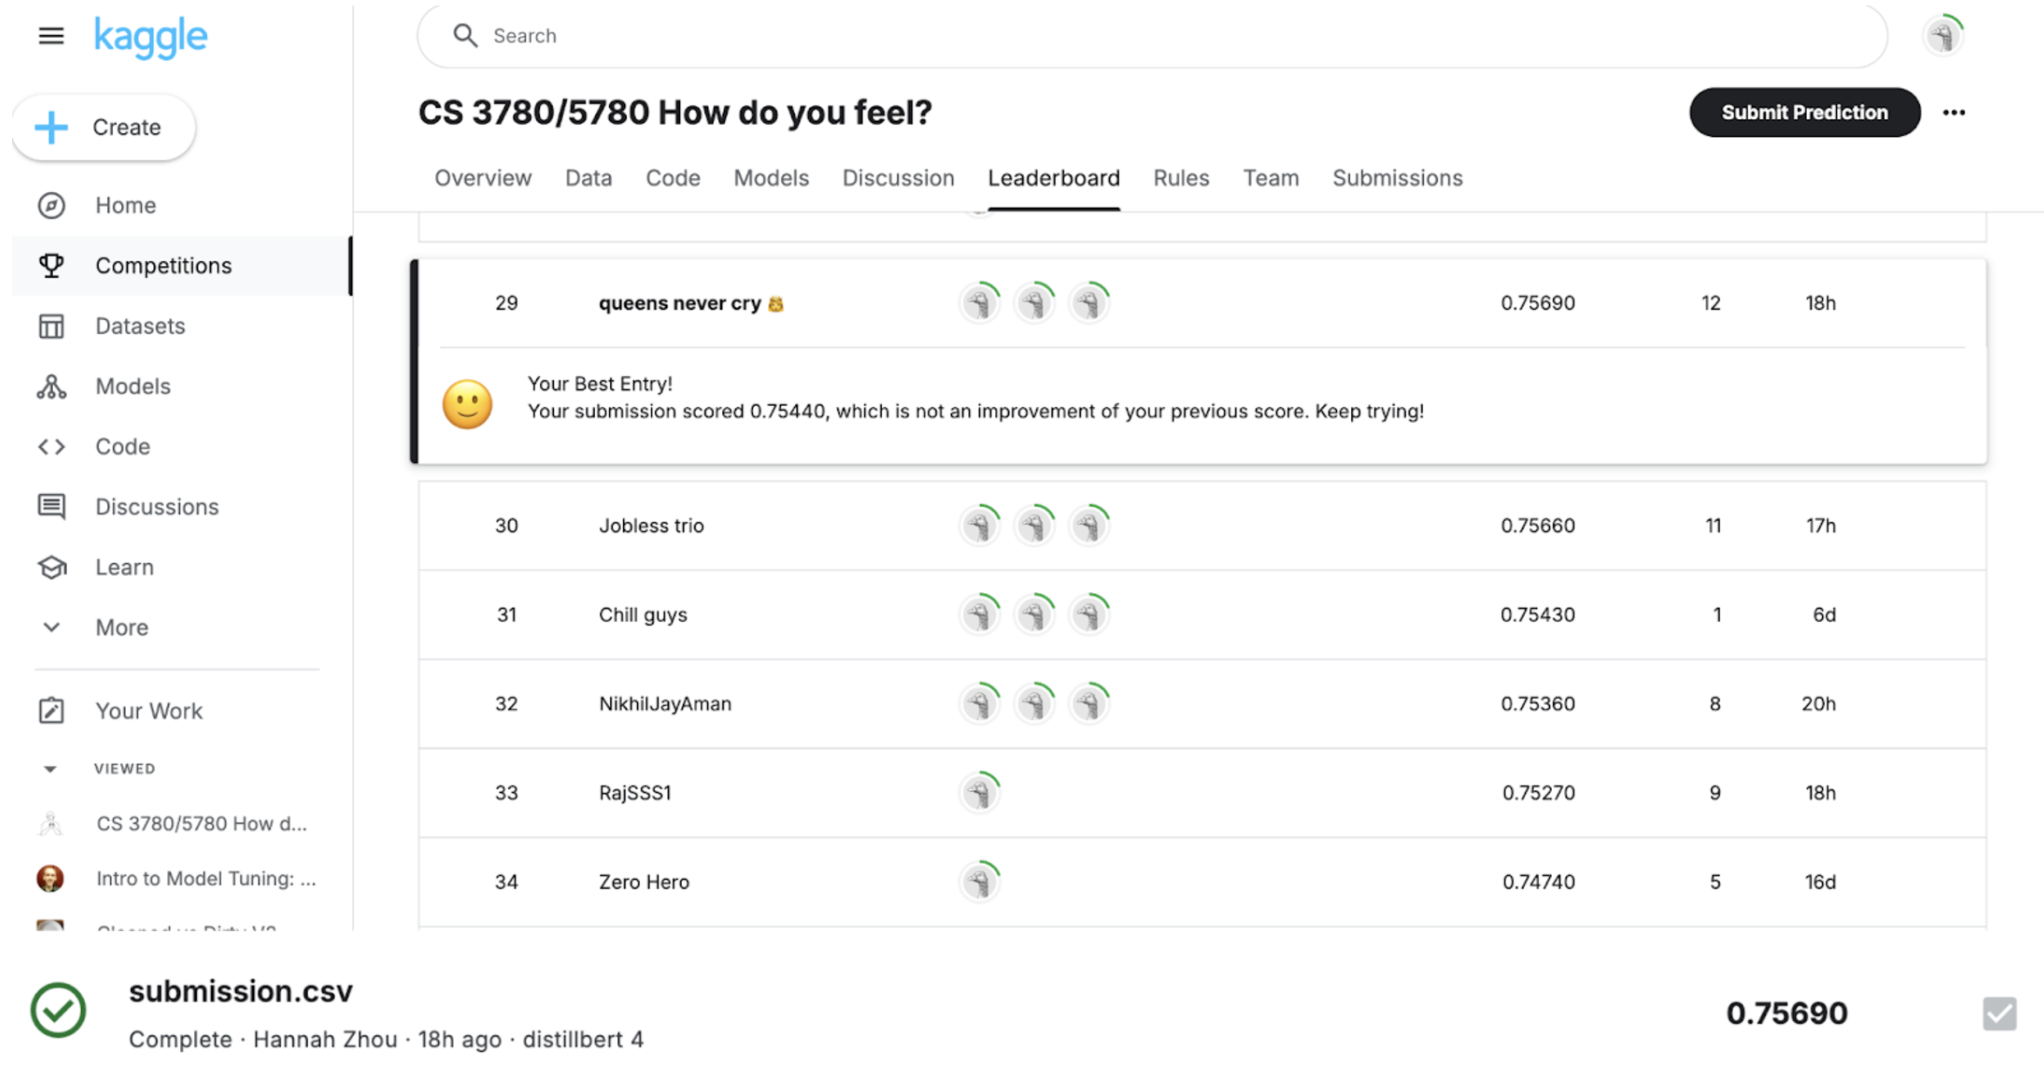

### 2.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.
Finally, as our creative solution to beat Zero Hero, we decided to use a transformer in order to capture the rich contextual relationships in text that our previous SVM approach did not. Specifically, we decided to use `DistillBERT-based-uncased`. which is a smaller model compared to BERT, a very well-known transformer model. They are both trained on lowercase English words. We used the Hugging Face library to load the model and tokenizer. We used the `DistillBERTForSequenceClassification` model, which is a fine-tuned version of DistillBERT for sequence classification tasks. We used the `AdamW optimizer` and the `SparseCategoricalCrossentropy` loss function. Essentially, the tokenizer takes the textual data, which is an array of strings, and converts it into a tokenized representation. This includes token IDs (a unique number for each token) and attention mask (a binary mask that tells the model which tokens are padding and which are not. 1 for real tokens, 0 for padding tokens). Then, we train the model with our training dataset. 

We first tried many different configurations of hyperparameters. Fortunately, we quickly found a parameter, `max_length`, which significantly improved our accuracy. `Max_length` represents how big the token can be. It will be truncated if exceed the length, and if it's too short, extra information will be filled in. First, we started with a small `max_length` of around 5, and after realizing that our validation accuracy was increasing with `max_length`, we steadily increased until it stopped increasing the validation accuracy, reaching a value of 60 for it. We also realized that our best `batch size`, `epochs`, and `learning rate` were 16, 3, 5e-05, respectively, irrespective of `max_length`. **We ended up with a validation accuracy of 0.7746666669845581 and test accuracy of 0.75690.**

We also attempted to increase validation accuracy **by decreasing learning rate at a polynomial decay** as the number of epochs increases, which is an adaptive technique that Professor Dean mentioned in the Gradient Descent lecture. We tried it with the same optimal hyperparameters as before, and ended up with a higher validation accuracy, of 0.7773333191871643. However, when we actually ran this on the test set, it scored lower than with a test accuracy of 0.75440, without adaptive decreasing of learning rate. We believe that this is a result of model overfitting and opted to keep our previous approach and parameters.

For model selection, we divided up our training data into a training set and a validation set, again with a 70/30 split. Every epoch, we calculate the validation accuracy and loss. We save the model with the best validation accuracy to use for the testing dataset. Then we used `ParameterGrid` to find the best params (learning rate, max_length, num_epochs, and batch size) to find and save the model that produced the best validation accuracy, then used that model to find the test predictions. 

An issue that arose was that we encountered multiple memory issues due to our limited computer. However, we were able to fix this issue by processing every piece of data (training, validation, and testing) in batches.

<h2>Part 3: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The results should be presented in two columns in csv format: the first column is the data id (0-14999) and the second column includes the predictions for the test set. The first column must be named id and the second column must be named label (otherwise your submission will fail). A sample predication file can be downloaded from Kaggle for each problem. 
We provide how to save a csv file if you are running Notebook on Kaggle.

In [ ]:
# For Creative Part
id_column = id = range(15000) 
submission = pd.DataFrame({'id': id_column, 'label': test_predictions})
submission.to_csv('submission.csv', index=False)

print("Predictions saved to 'submission.csv'")

<h2>Part 4: Resources and Literature Used</h2><p>

Please cite the papers and open resources you used.

HuggingFace’s DistilBERT example usages: https://huggingface.co/docs/transformers/en/model_doc/distilbert 

scikit-learn Documentation for SVM and Grid Search

DMLC Documentation for XGBoost and finetuning hyperparameters
[XGBoost Parameters — xgboost 2.1.3 documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)

Chat GPT Prompts: 
- Suggestions for loss functions for unbalanced multi class
- Training loop for XG Boost with more fine grained control
- Are there any suggestions that can tune this better we have low validation?
contractions
- instead, can you do the opposite? take part of asentence like "do not" into don’t
-can you explain why parameters to hypertume for distillbert? 
-can you explain the purpose of maxlength? why does maxlength  give me resourceError